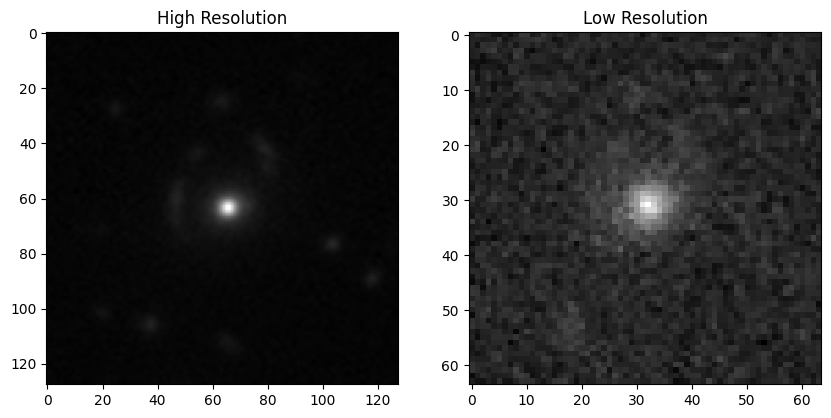

High Resolution Size:  (128, 128, 1)
Low Resolution Size:  (64, 64, 1)
High Resolution Range:  0.0018911075 1.0107527
Low Resolution Range:  -0.0044042915 0.99870276


In [4]:
import os
import numpy as np




hr = "HR/HR_1.npy"
lr = "LR/LR_1.npy"

hr = np.load(hr)
lr = np.load(lr)
#reshaping
hr = np.transpose(hr, (1, 2, 0))
lr = np.transpose(lr, (1, 2, 0))

#plotting
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(hr , cmap='gray')
ax[0].set_title("High Resolution")
ax[1].imshow(lr , cmap='gray')
ax[1].set_title("Low Resolution")
plt.show()

#size
print("High Resolution Size: ", hr.shape)
print("Low Resolution Size: ", lr.shape)

#print range of pixel values
print("High Resolution Range: ", np.min(hr), np.max(hr))
print("Low Resolution Range: ", np.min(lr), np.max(lr))


In [2]:
import warnings
import torch
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, high_res_folder, low_res_folder, highres_transform, lowres_transform, both_transforms=None):
        self.high_res_folder = high_res_folder
        self.low_res_folder = low_res_folder
        self.highres_transform = highres_transform
        self.lowres_transform = lowres_transform
        self.both_transforms = both_transforms

        #get the file names for both high and low res images
        self.file_names = [f.split(".")[0] for f in os.listdir(high_res_folder)]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        high_res_path = os.path.join(self.high_res_folder, f"HR_{self.file_names[idx].split('_')[-1]}.npy")
        low_res_path = os.path.join(self.low_res_folder, f"LR_{self.file_names[idx].split('_')[-1]}.npy")

        high_res_image = np.load(high_res_path)
        low_res_image = np.load(low_res_path)
        
        high_res_image = np.transpose(high_res_image, (1, 2, 0))
        low_res_image = np.transpose(low_res_image, (1, 2, 0))


        if self.highres_transform:
            high_res_image = self.highres_transform(high_res_image)

        if self.lowres_transform:
            low_res_image = self.lowres_transform(low_res_image)

        return high_res_image, low_res_image


#sizes
high_res_folder = "HR"
low_res_folder = "LR"

high_res_transform = transforms.Compose([
                                        #zero to 1 scaling
                                        transforms.ToTensor(),
                                        transforms.Normalize(0, 1),
])
                                        
low_res_transform = transforms.Compose([
                                        #zero to 1 scaling
                                        transforms.ToTensor(),
                                        transforms.Normalize(0, 1),])

                                        

dataset = CustomDataset(high_res_folder, low_res_folder, high_res_transform, low_res_transform)
print("Number of samples: ", len(dataset))
print("Sample 0: ", dataset[0][0].shape, dataset[0][1].shape)






/home/arnesh/ai/yolo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of samples:  300
Sample 0:  torch.Size([1, 128, 128]) torch.Size([1, 64, 64])


In [4]:
import torch.nn as nn
from collections import OrderedDict
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch


def _make_pair(value):
    if isinstance(value, int):
        value = (value,) * 2
    return value


def conv_layer(in_channels,
               out_channels,
               kernel_size,
               bias=False):
    kernel_size = _make_pair(kernel_size)
    padding = (int((kernel_size[0] - 1) / 2), 
               int((kernel_size[1] - 1) / 2))
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size,
                     padding=padding,
                     bias=bias)


def activation(act_type, inplace=True, neg_slope=0.05, n_prelu=1):
    
    act_type = act_type.lower()
    if act_type == 'relu':
        layer = nn.ReLU(inplace)
    elif act_type == 'lrelu':
        layer = nn.LeakyReLU(neg_slope, inplace)
    elif act_type == 'prelu':
        layer = nn.PReLU(num_parameters=n_prelu, init=neg_slope)
    else:
        raise NotImplementedError(
            'activation layer [{:s}] is not found'.format(act_type))
    return layer


def sequential(*args):

    if len(args) == 1:
        if isinstance(args[0], OrderedDict):
            raise NotImplementedError(
                'sequential does not support OrderedDict input.')
        return args[0]
    modules = []
    for module in args:
        if isinstance(module, nn.Sequential):
            for submodule in module.children():
                modules.append(submodule)
        elif isinstance(module, nn.Module):
            modules.append(module)
    return nn.Sequential(*modules)


def pixelshuffle_block(in_channels,
                       out_channels,
                       upscale_factor=2,
                       kernel_size=3):
    conv = conv_layer(in_channels,
                      out_channels * (upscale_factor ** 2),
                      kernel_size)
    pixel_shuffle = nn.PixelShuffle(upscale_factor)
    return sequential(conv, pixel_shuffle)


class ESA(nn.Module):

    def __init__(self, esa_channels, n_feats, conv):
        super(ESA, self).__init__()
        f = esa_channels
        self.conv1 = conv(n_feats, f, kernel_size=1)
        self.conv_f = conv(f, f, kernel_size=1)
        self.conv2 = conv(f, f, kernel_size=3, stride=2, padding=0)
        self.conv3 = conv(f, f, kernel_size=3, padding=1)
        self.conv4 = conv(f, n_feats, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        c1_ = (self.conv1(x))
        c1 = self.conv2(c1_)
        v_max = F.max_pool2d(c1, kernel_size=7, stride=3)
        c3 = self.conv3(v_max)
        c3 = F.interpolate(c3, (x.size(2), x.size(3)),
                           mode='bilinear', align_corners=False)
        cf = self.conv_f(c1_)
        c4 = self.conv4(c3 + cf)
        m = self.sigmoid(c4)
        return x * m


class RRFB(nn.Module):
    def __init__(self,
                 in_channels,
                 mid_channels=None,
                 out_channels=None,
                 esa_channels=16):
        super(RRFB, self).__init__()

        if mid_channels is None:
            mid_channels = in_channels
        if out_channels is None:
            out_channels = in_channels

        self.c1_r = conv_layer(in_channels, mid_channels, 3)
        self.c2_r = conv_layer(mid_channels, mid_channels, 3)
        self.c3_r = conv_layer(mid_channels, in_channels, 3)

        self.c5 = conv_layer(in_channels, out_channels, 1)
        self.esa = ESA(esa_channels, out_channels, nn.Conv2d)

        self.act = activation('lrelu', neg_slope=0.05)

    def forward(self, x):
        out_33 = (self.c1_r(x))
        out = self.act(out_33)

        out_33 = (self.c2_r(out))
        out = self.act(out_33)

        out_33 = (self.c3_r(out))
        out = self.act(out_33)

        out = out + x
        out = self.esa(self.c5(out))

        return out


def make_model(args, parent=False):
    model = DIPNet()
    return model


class DIPNet(nn.Module):

    def __init__(self,
                 in_channels=3,
                 out_channels=3,
                 feature_channels=44,
                 upscale=4):
        super(DIPNet, self).__init__()

        self.conv_1 = conv_layer(in_channels,
                                       feature_channels,
                                       kernel_size=3)

        self.block_1 = RRFB(feature_channels, mid_channels=38)
        self.block_2 = RRFB(feature_channels, mid_channels=38)
        self.block_3 = RRFB(feature_channels, mid_channels=38)
        self.block_4 = RRFB(feature_channels, mid_channels=38)

        self.conv_2 = conv_layer(feature_channels,
                                   feature_channels,
                                   kernel_size=3)

        self.upsampler = pixelshuffle_block(feature_channels,
                                          out_channels,
                                          upscale_factor=upscale)

    def forward(self, x):
        out_feature = self.conv_1(x)

        out_b1 = self.block_1(out_feature)
        out_b2 = self.block_2(out_b1)
        out_b3 = self.block_3(out_b2)
        out_b4 = self.block_4(out_b3)


        out_low_resolution = self.conv_2(out_b4) + out_feature
        output = self.upsampler(out_low_resolution)

        return output

In [32]:
#Training DIPNet
import torch
import torch.nn as nn
from alive_progress import alive_bar

class DIPNetTrainer:
    def __init__(self, model, train_loader, val_loader, lr=1e-4, epochs=10, device="cuda"):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.lr = lr
        self.epochs = epochs
        self.device = device

        self.model.to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        #reduce lr on plateau
        self.sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=5, verbose=True )
        #self.sheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.5)
        #cosine annealing
        #self.sheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=10, eta_min=0 , verbose=True)

    def train(self):
        best_val_loss = 0.00105

        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0.0

            with alive_bar(len(self.train_loader) , force_tty = True) as bar:
                for i, data in enumerate(self.train_loader):
                    high_res, low_res = data
                    high_res, low_res = high_res.to(self.device , dtype=torch.float), low_res.to(self.device , dtype=torch.float)

                    self.optimizer.zero_grad()
                    outputs = self.model(low_res)
                    loss = self.criterion(outputs, high_res)
                    loss.backward()
                    self.optimizer.step()
                    self.sheduler.step(loss)

                    train_loss += loss.item()
                    bar()

            print(f"Epoch {epoch+1}/{self.epochs}, Loss: {train_loss/len(self.train_loader)}")
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                with alive_bar(len(self.val_loader) , force_tty = True) as bar:
                    for i, data in enumerate(self.val_loader):
                        high_res, low_res = data
                        high_res, low_res = high_res.to(self.device , dtype=torch.float), low_res.to(self.device , dtype=torch.float)

                        outputs = self.model(low_res)
                        loss = self.criterion(outputs, high_res)

                        val_loss += loss.item()
                        bar()

                print(f"Validation Loss: {val_loss/len(self.val_loader)}")
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    self.save_model("best_model_Superres_Task3b.pth")     
                    print("Model Saved with " , val_loss/len(self.val_loader))

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))

    def predict(self, low_res):
        self.model.eval()
        with torch.no_grad():
            low_res = low_res.to(self.device)
            output = self.model(low_res)
        return output
    
#Training
high_res_folder = "3b/HR"
low_res_folder = "3b/LR"

high_res_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        ])

low_res_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                       ])
dataset = CustomDataset(high_res_folder, low_res_folder, high_res_transform, low_res_transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

model = DIPNet(in_channels=1, out_channels=1, feature_channels=1000, upscale=2)

trainer = DIPNetTrainer(model, train_loader, val_loader, lr=0.0001, epochs=5000, device="cuda")


#sample model input
low_res = torch.rand(1, 1, 64, 64)
output = trainer.predict(low_res)
print("Output Size: ", output.shape)

Output Size:  torch.Size([1, 1, 128, 128])


In [33]:
#training
trainer.train()

on 16: Epoch 00017: reducing learning rate of group 0 to 5.0000e-05.            
on 22: Epoch 00023: reducing learning rate of group 0 to 2.5000e-05.            
on 28: Epoch 00029: reducing learning rate of group 0 to 1.2500e-05.            
on 34: Epoch 00035: reducing learning rate of group 0 to 6.2500e-06.            
on 56: Epoch 00057: reducing learning rate of group 0 to 3.1250e-06.            
|████████████████████████████████████████| 60/60 [100%] in 14.6s (4.08/s)       
Epoch 1/5000, Loss: 0.0020392804605459483
|████████████████████████████████████████| 15/15 [100%] in 1.2s (12.01/s)       
Validation Loss: 0.0009765634041589996
on 2: Epoch 00063: reducing learning rate of group 0 to 1.5625e-06.             
on 8: Epoch 00069: reducing learning rate of group 0 to 7.8125e-07.             
on 14: Epoch 00075: reducing learning rate of group 0 to 3.9063e-07.            
on 20: Epoch 00081: reducing learning rate of group 0 to 1.9531e-07.            
on 26: Epoch 00087: reducing

KeyboardInterrupt: 

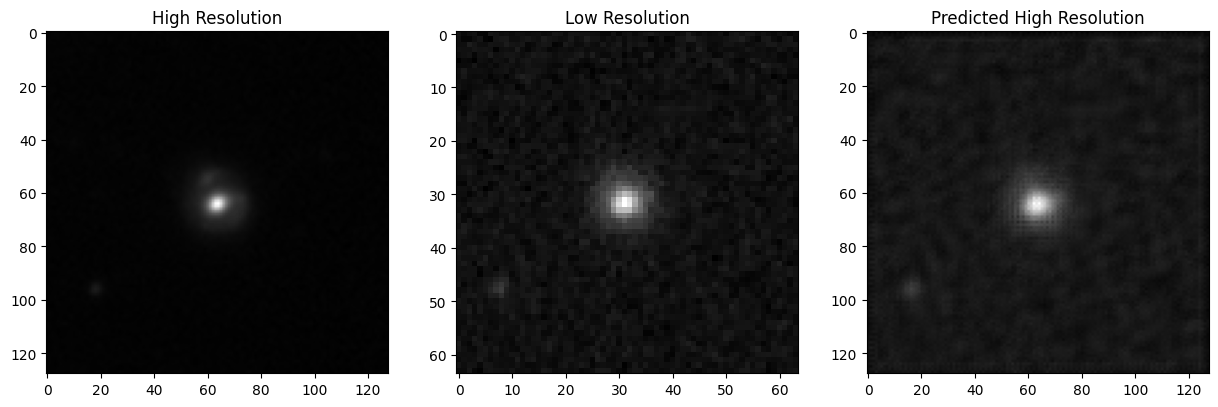

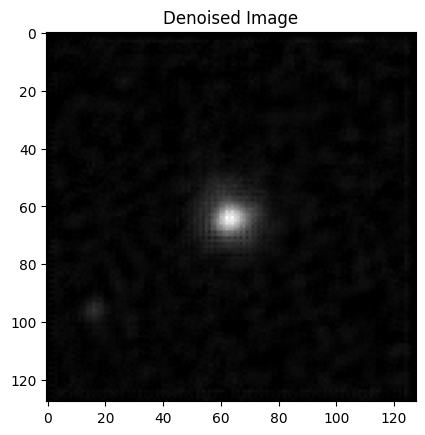

In [108]:
import matplotlib.pyplot as plt

high_res, low_res = val_dataset[0]
low_res = low_res.unsqueeze(0)
low_res = low_res.to(torch.float)
output = trainer.predict(low_res)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(high_res.squeeze(0).squeeze(0) , cmap='gray')
ax[0].set_title("High Resolution")
ax[1].imshow(low_res.squeeze(0).squeeze(0) , cmap='gray')
ax[1].set_title("Low Resolution")
ax[2].imshow(output.cpu().squeeze(0).squeeze(0) , cmap='gray')
ax[2].set_title("Predicted High Resolution")
plt.show()

#applying gaussian blur on predicted image
import cv2
output = output.cpu().squeeze(0).squeeze(0).numpy()
output = np.maximum(output, 0.02)

plt.imshow(output, cmap='gray')
plt.title("Denoised Image")
plt.show()

In [110]:
# MSE (Mean Squared Error), SSIM (Structural Similarity Index), PSNR (Peak Signal-to-Noise Ratio)
from skimage.metrics import peak_signal_noise_ratio
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim


def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def psnr(y_true, y_pred):
    return peak_signal_noise_ratio(y_true, y_pred, data_range=y_pred.max() - y_pred.min())

def ssim_score(y_true, y_pred):
    return ssim(y_true, y_pred, data_range=y_pred.max() - y_pred.min())

metrics = {'MSE': [], 'PSNR': [], 'SSIM': []}


with alive_bar(len(val_dataset) , force_tty = True) as bar:
    for i in range(len(val_dataset)):
        high_res, low_res = val_dataset[i]
        low_res = low_res.unsqueeze(0)
        low_res = low_res.to(torch.float)
        output = trainer.predict(low_res)

        high_res = high_res.squeeze(0).squeeze(0).numpy()
        output = output.cpu().squeeze(0).squeeze(0).numpy()
        low_res = low_res.squeeze(0).squeeze(0).numpy()


        metrics['MSE'].append(mse(high_res, output))
        metrics['PSNR'].append(psnr(high_res, output))
        metrics['SSIM'].append(ssim_score(high_res, output))
        bar()

average_metrics = {metric: np.mean(values) for metric, values in metrics.items()}
average_metrics


|████████████████████████████████████████| 60/60 [100%] in 1.2s (49.02/s)       


{'MSE': 0.0009894068, 'PSNR': 31.101165297120726, 'SSIM': 0.6178935588321165}

In [111]:
#on training data
metrics = {'MSE': [], 'PSNR': [], 'SSIM': []}

with alive_bar(len(train_dataset) , force_tty = True) as bar:
    for i in range(len(train_dataset)):
        high_res, low_res = train_dataset[i]
        low_res = low_res.unsqueeze(0)
        low_res = low_res.to(torch.float)
        output = trainer.predict(low_res)

        high_res = high_res.squeeze(0).squeeze(0).numpy()
        output = output.cpu().squeeze(0).squeeze(0).numpy()
        low_res = low_res.squeeze(0).squeeze(0).numpy()

        metrics['MSE'].append(mse(high_res, output))
        metrics['PSNR'].append(psnr(high_res, output))
        metrics['SSIM'].append(ssim_score(high_res, output))
        bar()

average_metrics = {metric: np.mean(values) for metric, values in metrics.items()}
average_metrics

|████████████████████████████████████████| 240/240 [100%] in 5.0s (47.64/s)     


{'MSE': 0.0017191207, 'PSNR': 30.4326676813878, 'SSIM': 0.594018632163009}

In [114]:
# #Swin Transformer
# # -----------------------------------------------------------------------------------
# # SwinIR: Image Restoration Using Swin Transformer, https://arxiv.org/abs/2108.10257
# # Originally Written by Ze Liu, Modified by Jingyun Liang.
# # -----------------------------------------------------------------------------------

# import math
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.utils.checkpoint as checkpoint
# from timm.models.layers import DropPath, to_2tuple, trunc_normal_


# class Mlp(nn.Module):
#     def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
#         super().__init__()
#         out_features = out_features or in_features
#         hidden_features = hidden_features or in_features
#         self.fc1 = nn.Linear(in_features, hidden_features)
#         self.act = act_layer()
#         self.fc2 = nn.Linear(hidden_features, out_features)
#         self.drop = nn.Dropout(drop)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.act(x)
#         x = self.drop(x)
#         x = self.fc2(x)
#         x = self.drop(x)
#         return x


# def window_partition(x, window_size):
#     """
#     Args:
#         x: (B, H, W, C)
#         window_size (int): window size

#     Returns:
#         windows: (num_windows*B, window_size, window_size, C)
#     """
#     B, H, W, C = x.shape
#     x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
#     windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
#     return windows


# def window_reverse(windows, window_size, H, W):
#     """
#     Args:
#         windows: (num_windows*B, window_size, window_size, C)
#         window_size (int): Window size
#         H (int): Height of image
#         W (int): Width of image

#     Returns:
#         x: (B, H, W, C)
#     """
#     B = int(windows.shape[0] / (H * W / window_size / window_size))
#     x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
#     x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
#     return x


# class WindowAttention(nn.Module):
#     r""" Window based multi-head self attention (W-MSA) module with relative position bias.
#     It supports both of shifted and non-shifted window.

#     Args:
#         dim (int): Number of input channels.
#         window_size (tuple[int]): The height and width of the window.
#         num_heads (int): Number of attention heads.
#         qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
#         qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
#         attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
#         proj_drop (float, optional): Dropout ratio of output. Default: 0.0
#     """

#     def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

#         super().__init__()
#         self.dim = dim
#         self.window_size = window_size  # Wh, Ww
#         self.num_heads = num_heads
#         head_dim = dim // num_heads
#         self.scale = qk_scale or head_dim ** -0.5

#         # define a parameter table of relative position bias
#         self.relative_position_bias_table = nn.Parameter(
#             torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

#         # get pair-wise relative position index for each token inside the window
#         coords_h = torch.arange(self.window_size[0])
#         coords_w = torch.arange(self.window_size[1])
#         coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
#         coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
#         relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
#         relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
#         relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
#         relative_coords[:, :, 1] += self.window_size[1] - 1
#         relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
#         relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
#         self.register_buffer("relative_position_index", relative_position_index)

#         self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
#         self.attn_drop = nn.Dropout(attn_drop)
#         self.proj = nn.Linear(dim, dim)

#         self.proj_drop = nn.Dropout(proj_drop)

#         trunc_normal_(self.relative_position_bias_table, std=.02)
#         self.softmax = nn.Softmax(dim=-1)

#     def forward(self, x, mask=None):
#         """
#         Args:
#             x: input features with shape of (num_windows*B, N, C)
#             mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
#         """
#         B_, N, C = x.shape
#         qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
#         q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

#         q = q * self.scale
#         attn = (q @ k.transpose(-2, -1))

#         relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
#             self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
#         relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
#         attn = attn + relative_position_bias.unsqueeze(0)

#         if mask is not None:
#             nW = mask.shape[0]
#             attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
#             attn = attn.view(-1, self.num_heads, N, N)
#             attn = self.softmax(attn)
#         else:
#             attn = self.softmax(attn)

#         attn = self.attn_drop(attn)

#         x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
#         x = self.proj(x)
#         x = self.proj_drop(x)
#         return x

#     def extra_repr(self) -> str:
#         return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

#     def flops(self, N):
#         # calculate flops for 1 window with token length of N
#         flops = 0
#         # qkv = self.qkv(x)
#         flops += N * self.dim * 3 * self.dim
#         # attn = (q @ k.transpose(-2, -1))
#         flops += self.num_heads * N * (self.dim // self.num_heads) * N
#         #  x = (attn @ v)
#         flops += self.num_heads * N * N * (self.dim // self.num_heads)
#         # x = self.proj(x)
#         flops += N * self.dim * self.dim
#         return flops


# class SwinTransformerBlock(nn.Module):
#     r""" Swin Transformer Block.

#     Args:
#         dim (int): Number of input channels.
#         input_resolution (tuple[int]): Input resulotion.
#         num_heads (int): Number of attention heads.
#         window_size (int): Window size.
#         shift_size (int): Shift size for SW-MSA.
#         mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
#         qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
#         qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
#         drop (float, optional): Dropout rate. Default: 0.0
#         attn_drop (float, optional): Attention dropout rate. Default: 0.0
#         drop_path (float, optional): Stochastic depth rate. Default: 0.0
#         act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
#         norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
#     """

#     def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
#                  mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
#                  act_layer=nn.GELU, norm_layer=nn.LayerNorm):
#         super().__init__()
#         self.dim = dim
#         self.input_resolution = input_resolution
#         self.num_heads = num_heads
#         self.window_size = window_size
#         self.shift_size = shift_size
#         self.mlp_ratio = mlp_ratio
#         if min(self.input_resolution) <= self.window_size:
#             # if window size is larger than input resolution, we don't partition windows
#             self.shift_size = 0
#             self.window_size = min(self.input_resolution)
#         assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

#         self.norm1 = norm_layer(dim)
#         self.attn = WindowAttention(
#             dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
#             qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

#         self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
#         self.norm2 = norm_layer(dim)
#         mlp_hidden_dim = int(dim * mlp_ratio)
#         self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

#         if self.shift_size > 0:
#             attn_mask = self.calculate_mask(self.input_resolution)
#         else:
#             attn_mask = None

#         self.register_buffer("attn_mask", attn_mask)

#     def calculate_mask(self, x_size):
#         # calculate attention mask for SW-MSA
#         H, W = x_size
#         img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
#         h_slices = (slice(0, -self.window_size),
#                     slice(-self.window_size, -self.shift_size),
#                     slice(-self.shift_size, None))
#         w_slices = (slice(0, -self.window_size),
#                     slice(-self.window_size, -self.shift_size),
#                     slice(-self.shift_size, None))
#         cnt = 0
#         for h in h_slices:
#             for w in w_slices:
#                 img_mask[:, h, w, :] = cnt
#                 cnt += 1

#         mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
#         mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
#         attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
#         attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

#         return attn_mask

#     def forward(self, x, x_size):
#         H, W = x_size
#         B, L, C = x.shape
#         # assert L == H * W, "input feature has wrong size"

#         shortcut = x
#         x = self.norm1(x)
#         x = x.view(B, H, W, C)

#         # cyclic shift
#         if self.shift_size > 0:
#             shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
#         else:
#             shifted_x = x

#         # partition windows
#         x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
#         x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

#         # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size
#         if self.input_resolution == x_size:
#             attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
#         else:
#             attn_windows = self.attn(x_windows, mask=self.calculate_mask(x_size).to(x.device))

#         # merge windows
#         attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
#         shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

#         # reverse cyclic shift
#         if self.shift_size > 0:
#             x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
#         else:
#             x = shifted_x
#         x = x.view(B, H * W, C)

#         # FFN
#         x = shortcut + self.drop_path(x)
#         x = x + self.drop_path(self.mlp(self.norm2(x)))

#         return x

#     def extra_repr(self) -> str:
#         return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
#                f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

#     def flops(self):
#         flops = 0
#         H, W = self.input_resolution
#         # norm1
#         flops += self.dim * H * W
#         # W-MSA/SW-MSA
#         nW = H * W / self.window_size / self.window_size
#         flops += nW * self.attn.flops(self.window_size * self.window_size)
#         # mlp
#         flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
#         # norm2
#         flops += self.dim * H * W
#         return flops


# class PatchMerging(nn.Module):
#     r""" Patch Merging Layer.

#     Args:
#         input_resolution (tuple[int]): Resolution of input feature.
#         dim (int): Number of input channels.
#         norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
#     """

#     def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
#         super().__init__()
#         self.input_resolution = input_resolution
#         self.dim = dim
#         self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
#         self.norm = norm_layer(4 * dim)

#     def forward(self, x):
#         """
#         x: B, H*W, C
#         """
#         H, W = self.input_resolution
#         B, L, C = x.shape
#         assert L == H * W, "input feature has wrong size"
#         assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

#         x = x.view(B, H, W, C)

#         x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
#         x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
#         x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
#         x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
#         x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
#         x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

#         x = self.norm(x)
#         x = self.reduction(x)

#         return x

#     def extra_repr(self) -> str:
#         return f"input_resolution={self.input_resolution}, dim={self.dim}"

#     def flops(self):
#         H, W = self.input_resolution
#         flops = H * W * self.dim
#         flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
#         return flops


# class BasicLayer(nn.Module):
#     """ A basic Swin Transformer layer for one stage.

#     Args:
#         dim (int): Number of input channels.
#         input_resolution (tuple[int]): Input resolution.
#         depth (int): Number of blocks.
#         num_heads (int): Number of attention heads.
#         window_size (int): Local window size.
#         mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
#         qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
#         qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
#         drop (float, optional): Dropout rate. Default: 0.0
#         attn_drop (float, optional): Attention dropout rate. Default: 0.0
#         drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
#         norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
#         downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
#         use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
#     """

#     def __init__(self, dim, input_resolution, depth, num_heads, window_size,
#                  mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
#                  drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

#         super().__init__()
#         self.dim = dim
#         self.input_resolution = input_resolution
#         self.depth = depth
#         self.use_checkpoint = use_checkpoint

#         # build blocks
#         self.blocks = nn.ModuleList([
#             SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
#                                  num_heads=num_heads, window_size=window_size,
#                                  shift_size=0 if (i % 2 == 0) else window_size // 2,
#                                  mlp_ratio=mlp_ratio,
#                                  qkv_bias=qkv_bias, qk_scale=qk_scale,
#                                  drop=drop, attn_drop=attn_drop,
#                                  drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
#                                  norm_layer=norm_layer)
#             for i in range(depth)])

#         # patch merging layer
#         if downsample is not None:
#             self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
#         else:
#             self.downsample = None

#     def forward(self, x, x_size):
#         for blk in self.blocks:
#             if self.use_checkpoint:
#                 x = checkpoint.checkpoint(blk, x, x_size)
#             else:
#                 x = blk(x, x_size)
#         if self.downsample is not None:
#             x = self.downsample(x)
#         return x

#     def extra_repr(self) -> str:
#         return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

#     def flops(self):
#         flops = 0
#         for blk in self.blocks:
#             flops += blk.flops()
#         if self.downsample is not None:
#             flops += self.downsample.flops()
#         return flops


# class RSTB(nn.Module):
#     """Residual Swin Transformer Block (RSTB).

#     Args:
#         dim (int): Number of input channels.
#         input_resolution (tuple[int]): Input resolution.
#         depth (int): Number of blocks.
#         num_heads (int): Number of attention heads.
#         window_size (int): Local window size.
#         mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
#         qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
#         qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
#         drop (float, optional): Dropout rate. Default: 0.0
#         attn_drop (float, optional): Attention dropout rate. Default: 0.0
#         drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
#         norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
#         downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
#         use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
#         img_size: Input image size.
#         patch_size: Patch size.
#         resi_connection: The convolutional block before residual connection.
#     """

#     def __init__(self, dim, input_resolution, depth, num_heads, window_size,
#                  mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
#                  drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
#                  img_size=224, patch_size=4, resi_connection='1conv'):
#         super(RSTB, self).__init__()

#         self.dim = dim
#         self.input_resolution = input_resolution

#         self.residual_group = BasicLayer(dim=dim,
#                                          input_resolution=input_resolution,
#                                          depth=depth,
#                                          num_heads=num_heads,
#                                          window_size=window_size,
#                                          mlp_ratio=mlp_ratio,
#                                          qkv_bias=qkv_bias, qk_scale=qk_scale,
#                                          drop=drop, attn_drop=attn_drop,
#                                          drop_path=drop_path,
#                                          norm_layer=norm_layer,
#                                          downsample=downsample,
#                                          use_checkpoint=use_checkpoint)

#         if resi_connection == '1conv':
#             self.conv = nn.Conv2d(dim, dim, 3, 1, 1)
#         elif resi_connection == '3conv':
#             # to save parameters and memory
#             self.conv = nn.Sequential(nn.Conv2d(dim, dim // 4, 3, 1, 1), nn.LeakyReLU(negative_slope=0.2, inplace=True),
#                                       nn.Conv2d(dim // 4, dim // 4, 1, 1, 0),
#                                       nn.LeakyReLU(negative_slope=0.2, inplace=True),
#                                       nn.Conv2d(dim // 4, dim, 3, 1, 1))

#         self.patch_embed = PatchEmbed(
#             img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
#             norm_layer=None)

#         self.patch_unembed = PatchUnEmbed(
#             img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
#             norm_layer=None)

#     def forward(self, x, x_size):
#         return self.patch_embed(self.conv(self.patch_unembed(self.residual_group(x, x_size), x_size))) + x

#     def flops(self):
#         flops = 0
#         flops += self.residual_group.flops()
#         H, W = self.input_resolution
#         flops += H * W * self.dim * self.dim * 9
#         flops += self.patch_embed.flops()
#         flops += self.patch_unembed.flops()

#         return flops


# class PatchEmbed(nn.Module):
#     r""" Image to Patch Embedding

#     Args:
#         img_size (int): Image size.  Default: 224.
#         patch_size (int): Patch token size. Default: 4.
#         in_chans (int): Number of input image channels. Default: 3.
#         embed_dim (int): Number of linear projection output channels. Default: 96.
#         norm_layer (nn.Module, optional): Normalization layer. Default: None
#     """

#     def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
#         super().__init__()
#         img_size = to_2tuple(img_size)
#         patch_size = to_2tuple(patch_size)
#         patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
#         self.img_size = img_size
#         self.patch_size = patch_size
#         self.patches_resolution = patches_resolution
#         self.num_patches = patches_resolution[0] * patches_resolution[1]

#         self.in_chans = in_chans
#         self.embed_dim = embed_dim

#         if norm_layer is not None:
#             self.norm = norm_layer(embed_dim)
#         else:
#             self.norm = None

#     def forward(self, x):
#         x = x.flatten(2).transpose(1, 2)  # B Ph*Pw C
#         if self.norm is not None:
#             x = self.norm(x)
#         return x

#     def flops(self):
#         flops = 0
#         H, W = self.img_size
#         if self.norm is not None:
#             flops += H * W * self.embed_dim
#         return flops


# class PatchUnEmbed(nn.Module):
#     r""" Image to Patch Unembedding

#     Args:
#         img_size (int): Image size.  Default: 224.
#         patch_size (int): Patch token size. Default: 4.
#         in_chans (int): Number of input image channels. Default: 3.
#         embed_dim (int): Number of linear projection output channels. Default: 96.
#         norm_layer (nn.Module, optional): Normalization layer. Default: None
#     """

#     def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
#         super().__init__()
#         img_size = to_2tuple(img_size)
#         patch_size = to_2tuple(patch_size)
#         patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
#         self.img_size = img_size
#         self.patch_size = patch_size
#         self.patches_resolution = patches_resolution
#         self.num_patches = patches_resolution[0] * patches_resolution[1]

#         self.in_chans = in_chans
#         self.embed_dim = embed_dim

#     def forward(self, x, x_size):
#         B, HW, C = x.shape
#         x = x.transpose(1, 2).view(B, self.embed_dim, x_size[0], x_size[1])  # B Ph*Pw C
#         return x

#     def flops(self):
#         flops = 0
#         return flops


# class Upsample(nn.Sequential):
#     """Upsample module.

#     Args:
#         scale (int): Scale factor. Supported scales: 2^n and 3.
#         num_feat (int): Channel number of intermediate features.
#     """

#     def __init__(self, scale, num_feat):
#         m = []
#         if (scale & (scale - 1)) == 0:  # scale = 2^n
#             for _ in range(int(math.log(scale, 2))):
#                 m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
#                 m.append(nn.PixelShuffle(2))
#         elif scale == 3:
#             m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
#             m.append(nn.PixelShuffle(3))
#         else:
#             raise ValueError(f'scale {scale} is not supported. ' 'Supported scales: 2^n and 3.')
#         super(Upsample, self).__init__(*m)


# class UpsampleOneStep(nn.Sequential):
#     """UpsampleOneStep module (the difference with Upsample is that it always only has 1conv + 1pixelshuffle)
#        Used in lightweight SR to save parameters.

#     Args:
#         scale (int): Scale factor. Supported scales: 2^n and 3.
#         num_feat (int): Channel number of intermediate features.

#     """

#     def __init__(self, scale, num_feat, num_out_ch, input_resolution=None):
#         self.num_feat = num_feat
#         self.input_resolution = input_resolution
#         m = []
#         m.append(nn.Conv2d(num_feat, (scale ** 2) * num_out_ch, 3, 1, 1))
#         m.append(nn.PixelShuffle(scale))
#         super(UpsampleOneStep, self).__init__(*m)

#     def flops(self):
#         H, W = self.input_resolution
#         flops = H * W * self.num_feat * 3 * 9
#         return flops


# class SwinIR(nn.Module):
#     r""" SwinIR
#         A PyTorch impl of : `SwinIR: Image Restoration Using Swin Transformer`, based on Swin Transformer.

#     Args:
#         img_size (int | tuple(int)): Input image size. Default 64
#         patch_size (int | tuple(int)): Patch size. Default: 1
#         in_chans (int): Number of input image channels. Default: 3
#         embed_dim (int): Patch embedding dimension. Default: 96
#         depths (tuple(int)): Depth of each Swin Transformer layer.
#         num_heads (tuple(int)): Number of attention heads in different layers.
#         window_size (int): Window size. Default: 7
#         mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
#         qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
#         qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
#         drop_rate (float): Dropout rate. Default: 0
#         attn_drop_rate (float): Attention dropout rate. Default: 0
#         drop_path_rate (float): Stochastic depth rate. Default: 0.1
#         norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
#         ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
#         patch_norm (bool): If True, add normalization after patch embedding. Default: True
#         use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
#         upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
#         img_range: Image range. 1. or 255.
#         upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
#         resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
#     """

#     def __init__(self, img_size=64, patch_size=1, in_chans=3,
#                  embed_dim=96, depths=[6, 6, 6, 6], num_heads=[6, 6, 6, 6],
#                  window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
#                  drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
#                  norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
#                  use_checkpoint=False, upscale=2, img_range=1., upsampler='', resi_connection='1conv',
#                  **kwargs):
#         super(SwinIR, self).__init__()
#         num_in_ch = in_chans
#         num_out_ch = in_chans
#         num_feat = 64
#         self.img_range = img_range
#         if in_chans == 3:
#             rgb_mean = (0.4488, 0.4371, 0.4040)
#             self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
#         else:
#             self.mean = torch.zeros(1, 1, 1, 1)
#         self.upscale = upscale
#         self.upsampler = upsampler
#         self.window_size = window_size

#         #####################################################################################################
#         ################################### 1, shallow feature extraction ###################################
#         self.conv_first = nn.Conv2d(num_in_ch, embed_dim, 3, 1, 1)

#         #####################################################################################################
#         ################################### 2, deep feature extraction ######################################
#         self.num_layers = len(depths)
#         self.embed_dim = embed_dim
#         self.ape = ape
#         self.patch_norm = patch_norm
#         self.num_features = embed_dim
#         self.mlp_ratio = mlp_ratio

#         # split image into non-overlapping patches
#         self.patch_embed = PatchEmbed(
#             img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
#             norm_layer=norm_layer if self.patch_norm else None)
#         num_patches = self.patch_embed.num_patches
#         patches_resolution = self.patch_embed.patches_resolution
#         self.patches_resolution = patches_resolution

#         # merge non-overlapping patches into image
#         self.patch_unembed = PatchUnEmbed(
#             img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
#             norm_layer=norm_layer if self.patch_norm else None)

#         # absolute position embedding
#         if self.ape:
#             self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
#             trunc_normal_(self.absolute_pos_embed, std=.02)

#         self.pos_drop = nn.Dropout(p=drop_rate)

#         # stochastic depth
#         dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

#         # build Residual Swin Transformer blocks (RSTB)
#         self.layers = nn.ModuleList()
#         for i_layer in range(self.num_layers):
#             layer = RSTB(dim=embed_dim,
#                          input_resolution=(patches_resolution[0],
#                                            patches_resolution[1]),
#                          depth=depths[i_layer],
#                          num_heads=num_heads[i_layer],
#                          window_size=window_size,
#                          mlp_ratio=self.mlp_ratio,
#                          qkv_bias=qkv_bias, qk_scale=qk_scale,
#                          drop=drop_rate, attn_drop=attn_drop_rate,
#                          drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # no impact on SR results
#                          norm_layer=norm_layer,
#                          downsample=None,
#                          use_checkpoint=use_checkpoint,
#                          img_size=img_size,
#                          patch_size=patch_size,
#                          resi_connection=resi_connection

#                          )
#             self.layers.append(layer)
#         self.norm = norm_layer(self.num_features)

#         # build the last conv layer in deep feature extraction
#         if resi_connection == '1conv':
#             self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
#         elif resi_connection == '3conv':
#             # to save parameters and memory
#             self.conv_after_body = nn.Sequential(nn.Conv2d(embed_dim, embed_dim // 4, 3, 1, 1),
#                                                  nn.LeakyReLU(negative_slope=0.2, inplace=True),
#                                                  nn.Conv2d(embed_dim // 4, embed_dim // 4, 1, 1, 0),
#                                                  nn.LeakyReLU(negative_slope=0.2, inplace=True),
#                                                  nn.Conv2d(embed_dim // 4, embed_dim, 3, 1, 1))

#         #####################################################################################################
#         ################################ 3, high quality image reconstruction ################################
#         if self.upsampler == 'pixelshuffle':
#             # for classical SR
#             self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
#                                                       nn.LeakyReLU(inplace=True))
#             self.upsample = Upsample(upscale, num_feat)
#             self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
#         elif self.upsampler == 'pixelshuffledirect':
#             # for lightweight SR (to save parameters)
#             self.upsample = UpsampleOneStep(upscale, embed_dim, num_out_ch,
#                                             (patches_resolution[0], patches_resolution[1]))
#         elif self.upsampler == 'nearest+conv':
#             # for real-world SR (less artifacts)
#             self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
#                                                       nn.LeakyReLU(inplace=True))
#             self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
#             if self.upscale == 4:
#                 self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
#             self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
#             self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
#             self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
#         else:
#             # for image denoising and JPEG compression artifact reduction
#             self.conv_last = nn.Conv2d(embed_dim, num_out_ch, 3, 1, 1)

#         self.apply(self._init_weights)

#     def _init_weights(self, m):
#         if isinstance(m, nn.Linear):
#             trunc_normal_(m.weight, std=.02)
#             if isinstance(m, nn.Linear) and m.bias is not None:
#                 nn.init.constant_(m.bias, 0)
#         elif isinstance(m, nn.LayerNorm):
#             nn.init.constant_(m.bias, 0)
#             nn.init.constant_(m.weight, 1.0)

#     @torch.jit.ignore
#     def no_weight_decay(self):
#         return {'absolute_pos_embed'}

#     @torch.jit.ignore
#     def no_weight_decay_keywords(self):
#         return {'relative_position_bias_table'}

#     def check_image_size(self, x):
#         _, _, h, w = x.size()
#         mod_pad_h = (self.window_size - h % self.window_size) % self.window_size
#         mod_pad_w = (self.window_size - w % self.window_size) % self.window_size
#         x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
#         return x

#     def forward_features(self, x):
#         x_size = (x.shape[2], x.shape[3])
#         x = self.patch_embed(x)
#         if self.ape:
#             x = x + self.absolute_pos_embed
#         x = self.pos_drop(x)

#         for layer in self.layers:
#             x = layer(x, x_size)

#         x = self.norm(x)  # B L C
#         x = self.patch_unembed(x, x_size)

#         return x

#     def forward(self, x):
#         H, W = x.shape[2:]
#         x = self.check_image_size(x)
        
#         self.mean = self.mean.type_as(x)
#         x = (x - self.mean) * self.img_range

#         if self.upsampler == 'pixelshuffle':
#             # for classical SR
#             x = self.conv_first(x)
#             x = self.conv_after_body(self.forward_features(x)) + x
#             x = self.conv_before_upsample(x)
#             x = self.conv_last(self.upsample(x))
#         elif self.upsampler == 'pixelshuffledirect':
#             # for lightweight SR
#             x = self.conv_first(x)
#             x = self.conv_after_body(self.forward_features(x)) + x
#             x = self.upsample(x)
#         elif self.upsampler == 'nearest+conv':
#             # for real-world SR
#             x = self.conv_first(x)
#             x = self.conv_after_body(self.forward_features(x)) + x
#             x = self.conv_before_upsample(x)
#             x = self.lrelu(self.conv_up1(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
#             if self.upscale == 4:
#                 x = self.lrelu(self.conv_up2(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
#             x = self.conv_last(self.lrelu(self.conv_hr(x)))
#         else:
#             # for image denoising and JPEG compression artifact reduction
#             x_first = self.conv_first(x)
#             res = self.conv_after_body(self.forward_features(x_first)) + x_first
#             x = x + self.conv_last(res)

#         x = x / self.img_range + self.mean

#         return x[:, :, :H*self.upscale, :W*self.upscale]

#     def flops(self):
#         flops = 0
#         H, W = self.patches_resolution
#         flops += H * W * 3 * self.embed_dim * 9
#         flops += self.patch_embed.flops()
#         for i, layer in enumerate(self.layers):
#             flops += layer.flops()
#         flops += H * W * 3 * self.embed_dim * self.embed_dim
#         flops += self.upsample.flops()
#         return flops


# upscale = 2
# window_size =5
# height = (140 // upscale // window_size + 1) * window_size
# width = (140 // upscale // window_size + 1) * window_size
# model = SwinIR(upscale=2, img_size=(height, width),
#                 window_size=window_size, img_range=1., depths=[6, 6, 6, 6],
#                 embed_dim=60, num_heads=[6, 6, 6, 6], mlp_ratio=2, upsampler='pixelshuffledirect')

# x = torch.randn((1, 1, height, width))
# x = model(x)
# print(x.shape)

torch.Size([1, 3, 150, 150])


In [ ]:
# #ESRGAN
# import torch
# from torch import nn


# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, use_act, **kwargs):
#         super().__init__()
#         self.cnn = nn.Conv2d(
#             in_channels,
#             out_channels,
#             **kwargs,
#             bias=True,
#         )
#         self.act = nn.LeakyReLU(0.2, inplace=True) if use_act else nn.Identity()

#     def forward(self, x):
#         return self.act(self.cnn(x))


# class UpsampleBlock(nn.Module):
#     def __init__(self, in_c, scale_factor=2):
#         super().__init__()
#         self.upsample = nn.Upsample(scale_factor=scale_factor, mode="nearest")
#         self.conv = nn.Conv2d(in_c, in_c, 3, 1, 1, bias=True)
#         self.act = nn.LeakyReLU(0.2, inplace=True)

#     def forward(self, x):
#         return self.act(self.conv(self.upsample(x)))


# class DenseResidualBlock(nn.Module):
#     def __init__(self, in_channels, channels=32, residual_beta=0.2):
#         super().__init__()
#         self.residual_beta = residual_beta
#         self.blocks = nn.ModuleList()

#         for i in range(5):
#             self.blocks.append(
#                 ConvBlock(
#                     in_channels + channels * i,
#                     channels if i <= 3 else in_channels,
#                     kernel_size=3,
#                     stride=1,
#                     padding=1,
#                     use_act=True if i <= 3 else False,
#                 )
#             )

#     def forward(self, x):
#         new_inputs = x
#         for block in self.blocks:
#             out = block(new_inputs)
#             new_inputs = torch.cat([new_inputs, out], dim=1)
#         return self.residual_beta * out + x


# class RRDB(nn.Module):
#     def __init__(self, in_channels, residual_beta=0.2):
#         super().__init__()
#         self.residual_beta = residual_beta
#         self.rrdb = nn.Sequential(*[DenseResidualBlock(in_channels) for _ in range(3)])

#     def forward(self, x):
#         return self.rrdb(x) * self.residual_beta + x


# class Generator(nn.Module):
#     def __init__(self, in_channels=3, num_channels=64, num_blocks=23):
#         super().__init__()
#         self.initial = nn.Conv2d(
#             in_channels,
#             num_channels,
#             kernel_size=3,
#             stride=1,
#             padding=1,
#             bias=True,
#         )
#         self.residuals = nn.Sequential(*[RRDB(num_channels) for _ in range(num_blocks)])
#         self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
#         self.upsamples = nn.Sequential(
#             UpsampleBlock(num_channels), UpsampleBlock(num_channels),
#         )
#         self.final = nn.Sequential(
#             nn.Conv2d(num_channels, num_channels, 3, 1, 1, bias=True),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(num_channels, in_channels, 3, 1, 1, bias=True),
#         )

#     def forward(self, x):
#         initial = self.initial(x)
#         x = self.conv(self.residuals(initial)) + initial
#         x = self.upsamples(x)
#         return self.final(x)


# class Discriminator(nn.Module):
#     def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
#         super().__init__()
#         blocks = []
#         for idx, feature in enumerate(features):
#             blocks.append(
#                 ConvBlock(
#                     in_channels,
#                     feature,
#                     kernel_size=3,
#                     stride=1 + idx % 2,
#                     padding=1,
#                     use_act=True,
#                 ),
#             )
#             in_channels = feature

#         self.blocks = nn.Sequential(*blocks)
#         self.classifier = nn.Sequential(
#             nn.AdaptiveAvgPool2d((6, 6)),
#             nn.Flatten(),
#             nn.Linear(512 * 6 * 6, 1024),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(1024, 1),
#         )

#     def forward(self, x):
#         x = self.blocks(x)
#         return self.classifier(x)

# def initialize_weights(model, scale=0.1):
#     for m in model.modules():
#         if isinstance(m, nn.Conv2d):
#             nn.init.kaiming_normal_(m.weight.data)
#             m.weight.data *= scale

#         elif isinstance(m, nn.Linear):
#             nn.init.kaiming_normal_(m.weight.data)
#             m.weight.data *= scale








In [113]:
#Zero Shot Learning 
from PIL import Image
import torch
import torch.optim as optim
import torchvision as tv
import torch.utils.data as tud
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio
import time
import os
import copy
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
torch.backends.cudnn.deterministic = True



In [9]:
from torch import nn


class SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=9 // 2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x


#sample input
x = torch.randn(1, 1, 64, 64)
model = SRCNN()
output = model(x)
print(output.shape)

torch.Size([1, 1, 64, 64])


Number of samples:  300
Sample 0:  torch.Size([1, 64, 64]) torch.Size([1, 64, 64])


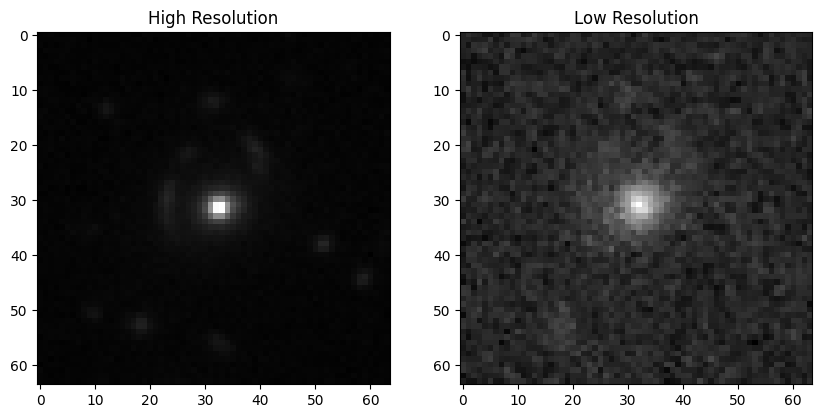

In [14]:
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, high_res_folder, low_res_folder, highres_transform, lowres_transform, both_transforms=None):
        self.high_res_folder = high_res_folder
        self.low_res_folder = low_res_folder
        self.highres_transform = highres_transform
        self.lowres_transform = lowres_transform
        self.both_transforms = both_transforms

        #get the file names for both high and low res images
        self.file_names = [f.split(".")[0] for f in os.listdir(high_res_folder)]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        high_res_path = os.path.join(self.high_res_folder, f"HR_{self.file_names[idx].split('_')[-1]}.npy")
        low_res_path = os.path.join(self.low_res_folder, f"LR_{self.file_names[idx].split('_')[-1]}.npy")

        high_res_image = np.load(high_res_path)
        low_res_image = np.load(low_res_path)
        
        high_res_image = np.transpose(high_res_image, (1, 2, 0))
        low_res_image = np.transpose(low_res_image, (1, 2, 0))


        if self.highres_transform:
            high_res_image = self.highres_transform(high_res_image)

        if self.lowres_transform:
            low_res_image = self.lowres_transform(low_res_image)

        return high_res_image, low_res_image


#sizes
high_res_folder = "HR"
low_res_folder = "LR"

high_res_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Resize((64, 64)),
])
                                        
low_res_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Resize((64, 64)),
])

                                        

dataset = CustomDataset(high_res_folder, low_res_folder, high_res_transform, low_res_transform)
print("Number of samples: ", len(dataset))
print("Sample 0: ", dataset[0][0].shape, dataset[0][1].shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(dataset[0][0].permute(1, 2, 0) , cmap="gray")
ax[0].set_title("High Resolution")
ax[1].imshow(dataset[0][1].permute(1, 2, 0) , cmap="gray")
ax[1].set_title("Low Resolution")
plt.show()





In [51]:
#train on SRCNN
import torch
import torch.optim as optim
from alive_progress import alive_bar
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model
model = SRCNN().to(device)

#loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#dataloader
train_aize = int(0.8 * len(dataset))
test_size = len(dataset) - train_aize
train_dataset, test_dataset = random_split(dataset, [train_aize, test_size])

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#train
num_epochs = 100
train_losses = []
test_losses = []
best_loss = 1

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0
    model.train()
    with alive_bar(len(train_loader)) as bar:
        for idx, (high_res, low_res) in enumerate(train_loader):
            high_res = high_res.to(device)
            low_res = low_res.to(device)

            optimizer.zero_grad()
            outputs = model(low_res)
            loss = criterion(outputs, high_res)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            bar()
    
    model.eval()
    with torch.no_grad():
        for idx, (high_res, low_res) in enumerate(test_loader):
            high_res = high_res.to(device)
            low_res = low_res.to(device)

            outputs = model(low_res)
            loss = criterion(outputs, high_res)
            test_loss += loss.item()
    
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), "best_model_SRCNN.pth")

|████████████████████████████████████████| 8/8 [100%] in 0.2s (33.74/s) 
Epoch 1/100, Train Loss: 0.0029, Test Loss: 0.0016
|████████████████████████████████████████| 8/8 [100%] in 0.2s (36.93/s) 
Epoch 2/100, Train Loss: 0.0015, Test Loss: 0.0014
|████████████████████████████████████████| 8/8 [100%] in 0.2s (35.72/s) 
Epoch 3/100, Train Loss: 0.0013, Test Loss: 0.0016
|████████████████████████████████████████| 8/8 [100%] in 0.2s (35.87/s) 
Epoch 4/100, Train Loss: 0.0013, Test Loss: 0.0012
|████████████████████████████████████████| 8/8 [100%] in 0.2s (37.25/s) 
Epoch 5/100, Train Loss: 0.0013, Test Loss: 0.0011
|████████████████████████████████████████| 8/8 [100%] in 0.2s (38.35/s) 
Epoch 6/100, Train Loss: 0.0012, Test Loss: 0.0013
|████████████████████████████████████████| 8/8 [100%] in 0.2s (36.53/s) 
Epoch 7/100, Train Loss: 0.0011, Test Loss: 0.0011
|████████████████████████████████████████| 8/8 [100%] in 0.2s (37.08/s) 
Epoch 8/100, Train Loss: 0.0011, Test Loss: 0.0013
|███████

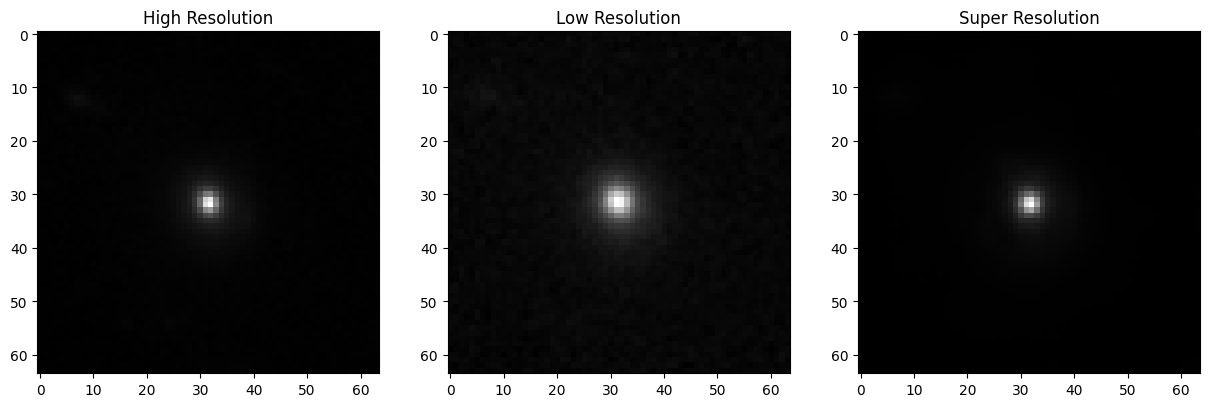

PSNR:  41.85189792061021
MSE:  4.5419925e-05
SSIM:  0.929612032617315


In [52]:
from skimage.metrics import peak_signal_noise_ratio
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim


def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def psnr(y_true, y_pred):
    return peak_signal_noise_ratio(y_true, y_pred, data_range=y_pred.max() - y_pred.min())

def ssim_score(y_true, y_pred):
    return ssim(y_true, y_pred, data_range=y_pred.max() - y_pred.min())

#load the best model
model.load_state_dict(torch.load("best_model_SRCNN.pth"))

#test the model
model.eval()
with torch.no_grad():
    high_res, low_res = test_dataset[0]
    high_res = high_res.unsqueeze(0).to(device)
    low_res = low_res.unsqueeze(0).to(device)

    output = model(low_res)
    high_res = high_res.cpu().numpy().squeeze(0)
    low_res = low_res.cpu().numpy().squeeze(0)
    output = output.cpu().numpy().squeeze(0)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    #changing dim
    high_res = np.transpose(high_res, (1, 2, 0))
    low_res = np.transpose(low_res, (1, 2, 0))
    output = np.transpose(output, (1, 2, 0))
    ax[0].imshow(high_res, cmap="gray")
    ax[0].set_title("High Resolution")
    ax[1].imshow(low_res, cmap="gray")
    ax[1].set_title("Low Resolution")
    ax[2].imshow(output, cmap="gray")
    ax[2].set_title("Super Resolution")
    plt.show()
    
    output = np.squeeze(output)
    high_res = np.squeeze(high_res)
    print("PSNR: ", psnr(high_res, output))
    print("MSE: ", mse(high_res, output))
    print("SSIM: ", ssim_score(high_res, output))




In [54]:
#average score for test set
import tqdm
scores = {"psnr": [], "mse": [], "ssim": []}
model.load_state_dict(torch.load("best_model_SRCNN.pth"))

model.eval()
for i in tqdm.tqdm(range(len(test_dataset))):
    with torch.no_grad():
        high_res, low_res = test_dataset[i]
        high_res = high_res.unsqueeze(0).to(device)
        low_res = low_res.unsqueeze(0).to(device)

        output = model(low_res)
        high_res = high_res.cpu().numpy().squeeze(0)
        low_res = low_res.cpu().numpy().squeeze(0)
        output = output.cpu().numpy().squeeze(0)

        output = np.squeeze(output)
        high_res = np.squeeze(high_res)
        scores["psnr"].append(psnr(high_res, output))
        scores["mse"].append(mse(high_res, output))
        scores["ssim"].append(ssim_score(high_res, output))

print("Average PSNR: ", np.mean(scores["psnr"]))
print("Average MSE: ", np.mean(scores["mse"]))
print("Average SSIM: ", np.mean(scores["ssim"]))

100%|██████████| 60/60 [00:00<00:00, 519.45it/s]

Average PSNR:  32.31514277564722
Average MSE:  0.0010093849
Average SSIM:  0.8210754923250707


In [10]:
#srresnet

import math
import torch.nn as nn
import basicblock as B



class SRResNet(nn.Module):
    def __init__(self, in_nc=3, out_nc=3, nc=64, nb=16, upscale=4, act_mode='R', upsample_mode='upconv'):
        super(SRResNet, self).__init__()
        n_upscale = int(math.log(upscale, 2))
        if upscale == 3:
            n_upscale = 1

        m_head = B.conv(in_nc, nc, mode='C')

        m_body = [B.ResBlock(nc, nc, mode='C'+act_mode+'C') for _ in range(nb)]
        m_body.append(B.conv(nc, nc, mode='C'))

        if upsample_mode == 'upconv':
            upsample_block = B.upsample_upconv
        elif upsample_mode == 'pixelshuffle':
            upsample_block = B.upsample_pixelshuffle
        elif upsample_mode == 'convtranspose':
            upsample_block = B.upsample_convtranspose
        else:
            raise NotImplementedError('upsample mode [{:s}] is not found'.format(upsample_mode))
        if upscale == 3:
            m_uper = upsample_block(nc, nc, mode='3'+act_mode)
        else:
            m_uper = [upsample_block(nc, nc, mode='2'+act_mode) for _ in range(n_upscale)]

        H_conv0 = B.conv(nc, nc, mode='C'+act_mode)
        H_conv1 = B.conv(nc, out_nc, bias=False, mode='C')
        m_tail = B.sequential(H_conv0, H_conv1)

        self.model = B.sequential(m_head, B.ShortcutBlock(B.sequential(*m_body)), *m_uper, m_tail)

    def forward(self, x):
        x = self.model(x)
        return x

In [77]:
#sample input
x = torch.randn(32, 1, 64, 64)
model = SRResNet(in_nc=1 , out_nc=1, nc=64, nb=16, upscale=2, act_mode='R', upsample_mode='upconv')
output = model(x)
print(output.shape)

torch.Size([32, 1, 128, 128])


Number of samples:  300
Sample 0:  torch.Size([1, 128, 128]) torch.Size([1, 64, 64])


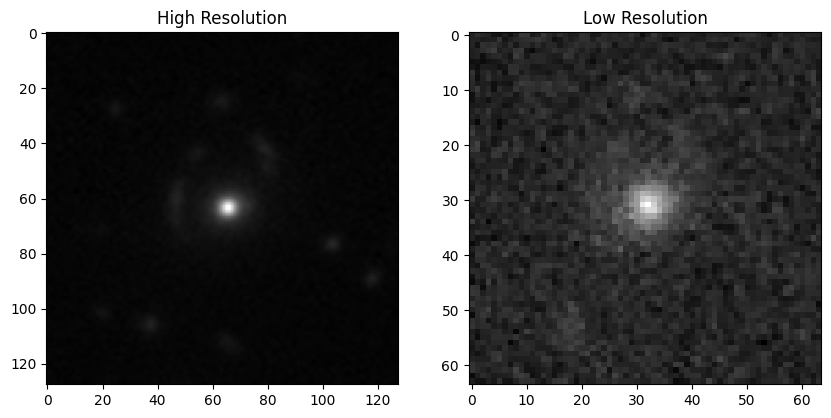

In [21]:
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, high_res_folder, low_res_folder, highres_transform, lowres_transform, both_transforms=None):
        self.high_res_folder = high_res_folder
        self.low_res_folder = low_res_folder
        self.highres_transform = highres_transform
        self.lowres_transform = lowres_transform
        self.both_transforms = both_transforms

        #get the file names for both high and low res images
        self.file_names = [f.split(".")[0] for f in os.listdir(high_res_folder)]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        high_res_path = os.path.join(self.high_res_folder, f"HR_{self.file_names[idx].split('_')[-1]}.npy")
        low_res_path = os.path.join(self.low_res_folder, f"LR_{self.file_names[idx].split('_')[-1]}.npy")

        high_res_image = np.load(high_res_path)
        low_res_image = np.load(low_res_path)
        
        high_res_image = np.transpose(high_res_image, (1, 2, 0))
        low_res_image = np.transpose(low_res_image, (1, 2, 0))


        if self.highres_transform:
            high_res_image = self.highres_transform(high_res_image)

        if self.lowres_transform:
            low_res_image = self.lowres_transform(low_res_image)

        return high_res_image, low_res_image


#sizes
high_res_folder = "HR"
low_res_folder = "LR"

high_res_transform = transforms.Compose([
                                        transforms.ToTensor(),
])
                                        
low_res_transform = transforms.Compose([
                                        transforms.ToTensor(),
])

                                        

dataset = CustomDataset(high_res_folder, low_res_folder, high_res_transform, low_res_transform)
print("Number of samples: ", len(dataset))
print("Sample 0: ", dataset[0][0].shape, dataset[0][1].shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(dataset[0][0].permute(1, 2, 0) , cmap="gray")
ax[0].set_title("High Resolution")
ax[1].imshow(dataset[0][1].permute(1, 2, 0) , cmap="gray")
ax[1].set_title("Low Resolution")
plt.show()





In [102]:
#train on SRResnet
import torch
import torch.optim as optim
from alive_progress import alive_bar
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model
model = SRResNet(in_nc=1 , out_nc=1, nc=64, nb=16, upscale=2, act_mode='R', upsample_mode='upconv').to(device)

#loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
#sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True

#dataloader
train_aize = int(0.8 * len(dataset))
test_size = len(dataset) - train_aize
train_dataset, test_dataset = random_split(dataset, [train_aize, test_size])

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#train
num_epochs = 400
train_losses = []
test_losses = []
best_loss = 1

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0
    model.train()
    with alive_bar(len(train_loader) , force_tty = True) as bar:
        for idx, (high_res, low_res) in enumerate(train_loader):
            high_res = high_res.to(device)
            low_res = low_res.to(device)

            optimizer.zero_grad()
            outputs = model(low_res)

            loss = criterion(outputs, high_res)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            #scheduler.step(loss)
            bar()
    
    model.eval()
    with torch.no_grad():
        for idx, (high_res, low_res) in enumerate(test_loader):
            high_res = high_res.to(device)
            low_res = low_res.to(device)

            outputs = model(low_res)
            loss = criterion(outputs, high_res)
            test_loss += loss.item()
    
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), "best_model_SRResnet.pth")
        print("Model saved")



|                                        | ▁▃▅ 0/8 [0%] in 0s (~0s, 0.0/s) 

|████████████████████████████████████████| 8/8 [100%] in 2.1s (3.56/s)          
Epoch 1/400, Train Loss: 0.0115, Test Loss: 0.0013
Model saved
|████████████████████████████████████████| 8/8 [100%] in 1.9s (3.86/s)          
Epoch 2/400, Train Loss: 0.0027, Test Loss: 0.0031
|████████████████████████████████████████| 8/8 [100%] in 1.9s (3.86/s)          
Epoch 3/400, Train Loss: 0.0022, Test Loss: 0.0015
|████████████████████████████████████████| 8/8 [100%] in 1.9s (3.87/s)          
Epoch 4/400, Train Loss: 0.0019, Test Loss: 0.0012
Model saved
|████████████████████████████████████████| 8/8 [100%] in 1.9s (3.86/s)          
Epoch 5/400, Train Loss: 0.0020, Test Loss: 0.0015
|████████████████████████████████████████| 8/8 [100%] in 1.9s (3.87/s)          
Epoch 6/400, Train Loss: 0.0016, Test Loss: 0.0010
Model saved
|████████████████████████████████████████| 8/8 [100%] in 1.9s (3.86/s)          
Epoch 7/400, Train Loss: 0.0015, Test Loss: 0.0010
Model saved
|███████████████████████████

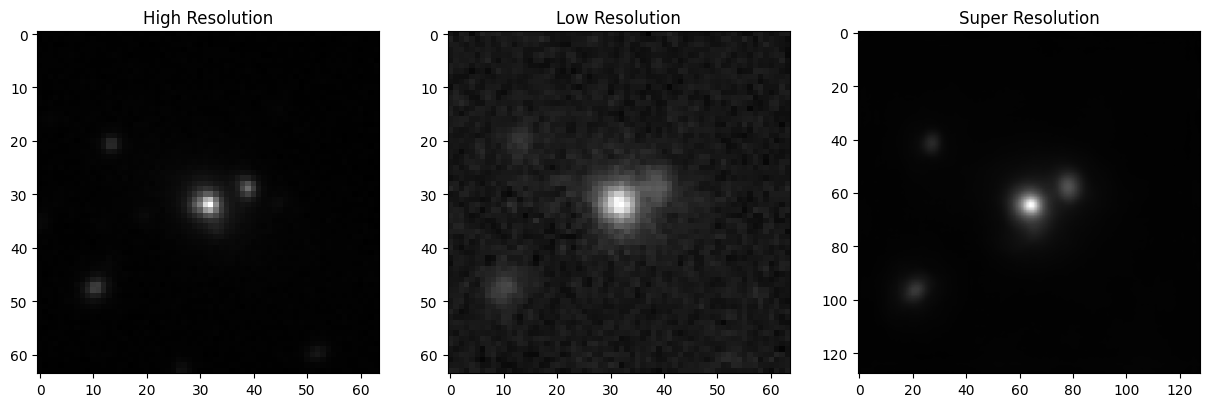

In [19]:
from skimage.metrics import peak_signal_noise_ratio
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim


def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def psnr(y_true, y_pred):
    return peak_signal_noise_ratio(y_true, y_pred, data_range=y_pred.max() - y_pred.min())

def ssim_score(y_true, y_pred):
    return ssim(y_true, y_pred, data_range=y_pred.max() - y_pred.min())

#load the best model
model = SRResNet(in_nc=1 , out_nc=1, nc=64, nb=16, upscale=2, act_mode='R', upsample_mode='upconv').to(device)

model.load_state_dict(torch.load("best_model_SRResnet.pth"))

#test the model
model.eval()
with torch.no_grad():
    high_res, low_res = test_dataset[0]
    high_res = high_res.unsqueeze(0).to(device)
    low_res = low_res.unsqueeze(0).to(device)

    output = model(low_res)
    high_res = high_res.cpu().numpy().squeeze(0)
    low_res = low_res.cpu().numpy().squeeze(0)
    output = output.cpu().numpy().squeeze(0)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    #changing dim
    high_res = np.transpose(high_res, (1, 2, 0))
    low_res = np.transpose(low_res, (1, 2, 0))
    output = np.transpose(output, (1, 2, 0))
    ax[0].imshow(high_res, cmap="gray")
    ax[0].set_title("High Resolution")
    ax[1].imshow(low_res, cmap="gray")
    ax[1].set_title("Low Resolution")
    ax[2].imshow(output, cmap="gray")
    ax[2].set_title("Super Resolution")
    plt.show()





In [22]:
#average score for test set
import tqdm
scores = {"psnr": [], "mse": [], "ssim": []}
model.load_state_dict(torch.load("best_model_SRResnet.pth"))
train_aize = int(0.8 * len(dataset))
test_size = len(dataset) - train_aize
train_dataset, test_dataset = random_split(dataset, [train_aize, test_size])
model.eval()
for i in tqdm.tqdm(range(len(test_dataset))):
    with torch.no_grad():
        high_res, low_res = test_dataset[i]
        high_res = high_res.unsqueeze(0).to(device)
        low_res = low_res.unsqueeze(0).to(device)

        output = model(low_res)
        high_res = high_res.cpu().numpy().squeeze(0)
        low_res = low_res.cpu().numpy().squeeze(0)
        output = output.cpu().numpy().squeeze(0)

        output = np.squeeze(output)
        high_res = np.squeeze(high_res)
        scores["psnr"].append(psnr(high_res, output))
        scores["mse"].append(mse(high_res, output))
        scores["ssim"].append(ssim_score(high_res, output))

print("Average PSNR: ", np.mean(scores["psnr"]))
print("Average MSE: ", np.mean(scores["mse"]))
print("Average SSIM: ", np.mean(scores["ssim"]))

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:00<00:00, 230.82it/s]

Average PSNR:  33.71580684417424
Average MSE:  0.0008005101
Average SSIM:  0.8130042336980025


In [1]:
#Zero Shot

import torch
import torch.nn as nn

class ZSSRNet(nn.Module):
    def __init__(self, input_channels=3, kernel_size=3, channels=64):
        super(ZSSRNet, self).__init__()

        self.conv0 = nn.Conv2d(input_channels, channels, kernel_size=kernel_size, padding=kernel_size//2, bias=True)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=kernel_size//2, bias=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=kernel_size//2, bias=True)
        self.conv3 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=kernel_size//2, bias=True)
        self.conv4 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=kernel_size//2, bias=True)
        self.conv5 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=kernel_size//2, bias=True)
        self.conv6 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=kernel_size//2, bias=True)
        self.conv7 = nn.Conv2d(channels, input_channels, kernel_size=kernel_size, padding=kernel_size//2, bias=True)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv0(x))
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.conv7(x)

        return x

In [2]:
#sample input

x = torch.randn(1, 3, 64, 64)
model = ZSSRNet()
output = model(x)
print(output.shape)

torch.Size([1, 3, 64, 64])


Number of samples:  300
Sample 0:  torch.Size([1, 64, 64]) torch.Size([1, 64, 64])


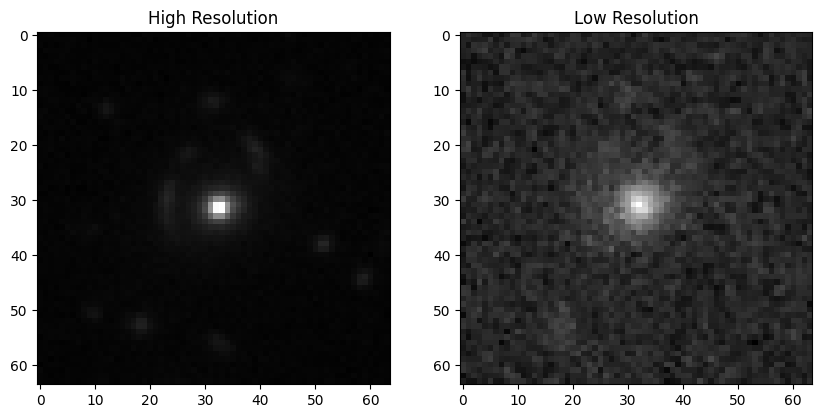

In [25]:
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, high_res_folder, low_res_folder, highres_transform, lowres_transform, both_transforms=None):
        self.high_res_folder = high_res_folder
        self.low_res_folder = low_res_folder
        self.highres_transform = highres_transform
        self.lowres_transform = lowres_transform
        self.both_transforms = both_transforms

        #get the file names for both high and low res images
        self.file_names = [f.split(".")[0] for f in os.listdir(high_res_folder)]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        high_res_path = os.path.join(self.high_res_folder, f"HR_{self.file_names[idx].split('_')[-1]}.npy")
        low_res_path = os.path.join(self.low_res_folder, f"LR_{self.file_names[idx].split('_')[-1]}.npy")

        high_res_image = np.load(high_res_path)
        low_res_image = np.load(low_res_path)
        
        high_res_image = np.transpose(high_res_image, (1, 2, 0))
        low_res_image = np.transpose(low_res_image, (1, 2, 0))


        if self.highres_transform:
            high_res_image = self.highres_transform(high_res_image)

        if self.lowres_transform:
            low_res_image = self.lowres_transform(low_res_image)

        return high_res_image, low_res_image


#sizes
high_res_folder = "HR"
low_res_folder = "LR"

high_res_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Resize((64, 64)),
])
                                        
low_res_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Resize((64, 64)),

])

                                        

dataset = CustomDataset(high_res_folder, low_res_folder, high_res_transform, low_res_transform)
print("Number of samples: ", len(dataset))
print("Sample 0: ", dataset[0][0].shape, dataset[0][1].shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(dataset[0][0].permute(1, 2, 0) , cmap="gray")
ax[0].set_title("High Resolution")
ax[1].imshow(dataset[0][1].permute(1, 2, 0) , cmap="gray")
ax[1].set_title("Low Resolution")
plt.show()

train_aize = int(0.8 * len(dataset))
test_size = len(dataset) - train_aize
train_dataset, test_dataset = random_split(dataset, [train_aize, test_size])



In [7]:
#train on ZSSR
import torch
import torch.optim as optim
from alive_progress import alive_bar
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model
model = ZSSRNet(input_channels=1).to(device)    

#loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
#sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

#dataloader
train_aize = int(0.8 * len(dataset))
test_size = len(dataset) - train_aize
train_dataset, test_dataset = random_split(dataset, [train_aize, test_size])

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

#train
num_epochs = 200
train_losses = []
test_losses = []
best_loss = 1

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0
    model.train()
    with alive_bar(len(train_loader) , force_tty = True) as bar:
        for idx, (high_res, low_res) in enumerate(train_loader):
            high_res = high_res.to(device)
            low_res = low_res.to(device)

            optimizer.zero_grad()
            outputs = model(low_res)

            loss = criterion(outputs, high_res)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            #scheduler.step(loss)
            bar()
    
    model.eval()
    with torch.no_grad():
        for idx, (high_res, low_res) in enumerate(test_loader):
            high_res = high_res.to(device)
            low_res = low_res.to(device)

            outputs = model(low_res)
            loss = criterion(outputs, high_res)
            test_loss += loss.item()
    
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), "best_model_ZSSR.pth")
        print("Model saved")



|████████████████████████████████████████| 30/30 [100%] in 1.1s (21.92/s)       
Epoch 1/200, Train Loss: 0.0020, Test Loss: 0.0015
Model saved
|████████████████████████████████████████| 30/30 [100%] in 0.4s (76.66/s)       
Epoch 2/200, Train Loss: 0.0029, Test Loss: 0.0024
|████████████████████████████████████████| 30/30 [100%] in 0.4s (80.23/s)       
Epoch 3/200, Train Loss: 0.0022, Test Loss: 0.0032
|████████████████████████████████████████| 30/30 [100%] in 0.3s (87.65/s)       
Epoch 4/200, Train Loss: 0.0023, Test Loss: 0.0021
|████████████████████████████████████████| 30/30 [100%] in 0.4s (83.68/s)       
Epoch 5/200, Train Loss: 0.0021, Test Loss: 0.0022
|████████████████████████████████████████| 30/30 [100%] in 0.4s (85.42/s)       
Epoch 6/200, Train Loss: 0.0015, Test Loss: 0.0012
Model saved
|████████████████████████████████████████| 30/30 [100%] in 0.3s (86.38/s)       
Epoch 7/200, Train Loss: 0.0015, Test Loss: 0.0011
Model saved
|███████████████████████████████████████

In [27]:
#average score for test set
import tqdm
scores = {"psnr": [], "mse": [], "ssim": []}
model = ZSSRNet(input_channels=1).to(device)   
model.load_state_dict(torch.load("best_model_ZSSR.pth"))


model.eval()
for i in tqdm.tqdm(range(len(test_dataset))):
    with torch.no_grad():
        high_res, low_res = test_dataset[i]
        high_res = high_res.unsqueeze(0).to(device)
        low_res = low_res.unsqueeze(0).to(device)

        output = model(low_res)
        high_res = high_res.cpu().numpy().squeeze(0)
        low_res = low_res.cpu().numpy().squeeze(0)
        output = output.cpu().numpy().squeeze(0)

        output = np.squeeze(output)
        high_res = np.squeeze(high_res)
        scores["psnr"].append(psnr(high_res, output))
        scores["mse"].append(mse(high_res, output))
        scores["ssim"].append(ssim_score(high_res, output))

print("Average PSNR: ", np.mean(scores["psnr"]))
print("Average MSE: ", np.mean(scores["mse"]))
print("Average SSIM: ", np.mean(scores["ssim"]))

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:00<00:00, 416.74it/s]

Average PSNR:  33.65021446709118
Average MSE:  0.0018982704
Average SSIM:  0.8366753910772713


In [28]:
#WaveMixSR

import torch
import torch.nn as nn
import wavemix
from wavemix import Level1Waveblock

class WaveMixSR(nn.Module):
    def __init__(
        self,
        *,
        depth,
        mult = 1,
        ff_channel = 16,
        final_dim = 16,
        dropout = 0.3,
    ):
        super().__init__()
        
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(Level1Waveblock(mult = mult, ff_channel = ff_channel, final_dim = final_dim, dropout = dropout))
        
        self.final = nn.Sequential(
            nn.Conv2d(final_dim,int(final_dim/2), 3, stride=1, padding=1),
            nn.Conv2d(int(final_dim/2), 1, 1)
        )


        self.path1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bicubic', align_corners = False),
            nn.Conv2d(1, int(final_dim/2), 3, 1, 1),
            nn.Conv2d(int(final_dim/2), final_dim, 3, 1, 1)
        )

        self.path2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bicubic', align_corners = False),
        )

    def forward(self, img):
        y = img[:, 0:1, :, :] 
        crcb = img[:, 1:3, :, :]

        y = self.path1(y)

        for attn in self.layers:
            y = attn(y) + y

        y = self.final(y)

        crcb = self.path2(crcb)
        
        return  torch.cat((y,crcb), dim=1)

model = WaveMixSR(
    depth = 4,
    mult = 1,
    ff_channel = 144,
    final_dim = 144,
    dropout = 0.3
).to(device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of samples:  300
Sample 0:  torch.Size([3, 128, 128]) torch.Size([3, 64, 64])


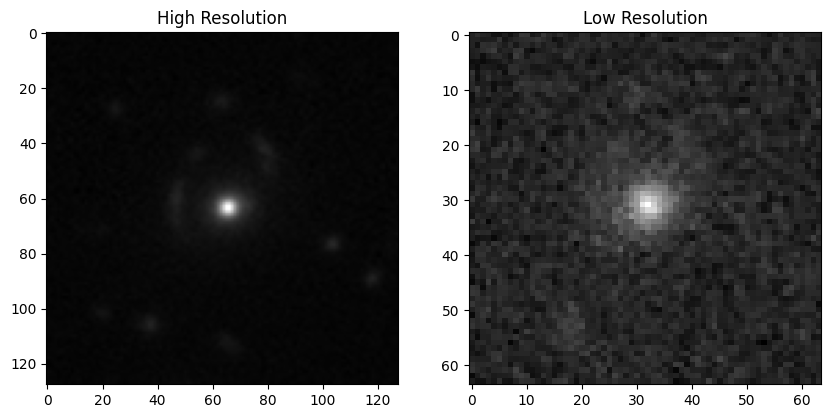

In [29]:
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, high_res_folder, low_res_folder, highres_transform, lowres_transform, both_transforms=None):
        self.high_res_folder = high_res_folder
        self.low_res_folder = low_res_folder
        self.highres_transform = highres_transform
        self.lowres_transform = lowres_transform
        self.both_transforms = both_transforms

        #get the file names for both high and low res images
        self.file_names = [f.split(".")[0] for f in os.listdir(high_res_folder)]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        high_res_path = os.path.join(self.high_res_folder, f"HR_{self.file_names[idx].split('_')[-1]}.npy")
        low_res_path = os.path.join(self.low_res_folder, f"LR_{self.file_names[idx].split('_')[-1]}.npy")

        high_res_image = np.load(high_res_path)
        low_res_image = np.load(low_res_path)
        
        high_res_image = np.transpose(high_res_image, (1, 2, 0))
        low_res_image = np.transpose(low_res_image, (1, 2, 0))

        #grayscale to 3 channel
        high_res_image = np.stack((high_res_image,)*3, axis=-1)
        low_res_image = np.stack((low_res_image,)*3, axis=-1)

        #squeeze
        high_res_image = np.squeeze(high_res_image)
        low_res_image = np.squeeze(low_res_image)

        if self.highres_transform:
            high_res_image = self.highres_transform(high_res_image)

        if self.lowres_transform:
            low_res_image = self.lowres_transform(low_res_image)

        return high_res_image, low_res_image


#sizes
high_res_folder = "HR"
low_res_folder = "LR"

high_res_transform = transforms.Compose([
                                        transforms.ToTensor(),
])
                                        
low_res_transform = transforms.Compose([
                                        transforms.ToTensor(),

])

                                        

dataset = CustomDataset(high_res_folder, low_res_folder, high_res_transform, low_res_transform)
print("Number of samples: ", len(dataset))
print("Sample 0: ", dataset[0][0].shape, dataset[0][1].shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(dataset[0][0].permute(1, 2, 0) , cmap="gray")
ax[0].set_title("High Resolution")
ax[1].imshow(dataset[0][1].permute(1, 2, 0) , cmap="gray")
ax[1].set_title("Low Resolution")
plt.show()





In [112]:
#Training WaveMixSR
import torch
import torch.optim as optim
from alive_progress import alive_bar
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model
model = WaveMixSR(
    depth = 4,
    mult = 1,
    ff_channel = 144,
    final_dim = 144,
    dropout = 0.2
).to(device)

#loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

#dataloader
train_aize = int(0.8 * len(dataset))
test_size = len(dataset) - train_aize
train_dataset, test_dataset = random_split(dataset, [train_aize, test_size])

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

#train
num_epochs = 200
train_losses = []
test_losses = []
best_loss = 1

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0
    model.train()
    with alive_bar(len(train_loader) , force_tty = True) as bar:
        for idx, (high_res, low_res) in enumerate(train_loader):
            high_res = high_res.to(device)
            low_res = low_res.to(device)
            optimizer.zero_grad()
            outputs = model(low_res)
            loss = criterion(outputs, high_res)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            #scheduler.step(loss)
            bar()
    
    model.eval()
    with torch.no_grad():
        for idx, (high_res, low_res) in enumerate(test_loader):
            high_res = high_res.to(device)
            low_res = low_res.to(device)

            outputs = model(low_res)
            loss = criterion(outputs, high_res)
            test_loss += loss.item()
    
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f}")

    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), "best_model_WaveMixSR_V2.pth")
        print("Model saved")



|                                        | ▁▃▅ 0/60 [0%] in 0s (~0s, 0.0/s) 

|████████████████████████████████████████| 60/60 [100%] in 4.0s (15.12/s)       
Epoch 1/200, Train Loss: 0.61724294, Test Loss: 0.03560783
Model saved
|████████████████████████████████████████| 60/60 [100%] in 4.0s (15.02/s)       
Epoch 2/200, Train Loss: 0.02413761, Test Loss: 0.00573417
Model saved
|████████████████████████████████████████| 60/60 [100%] in 4.0s (15.00/s)       
Epoch 3/200, Train Loss: 0.01609538, Test Loss: 0.00555165
Model saved
|████████████████████████████████████████| 60/60 [100%] in 4.0s (15.00/s)       
Epoch 4/200, Train Loss: 0.01229806, Test Loss: 0.00546745
Model saved
|████████████████████████████████████████| 60/60 [100%] in 4.0s (14.95/s)       
Epoch 5/200, Train Loss: 0.01055630, Test Loss: 0.00536367
Model saved
|████████████████████████████████████████| 60/60 [100%] in 4.0s (14.99/s)       
Epoch 6/200, Train Loss: 0.00935187, Test Loss: 0.00532257
Model saved
|████████████████████████████████████████| 60/60 [100%] in 4.0s (14.85/s)       
Epoch 7

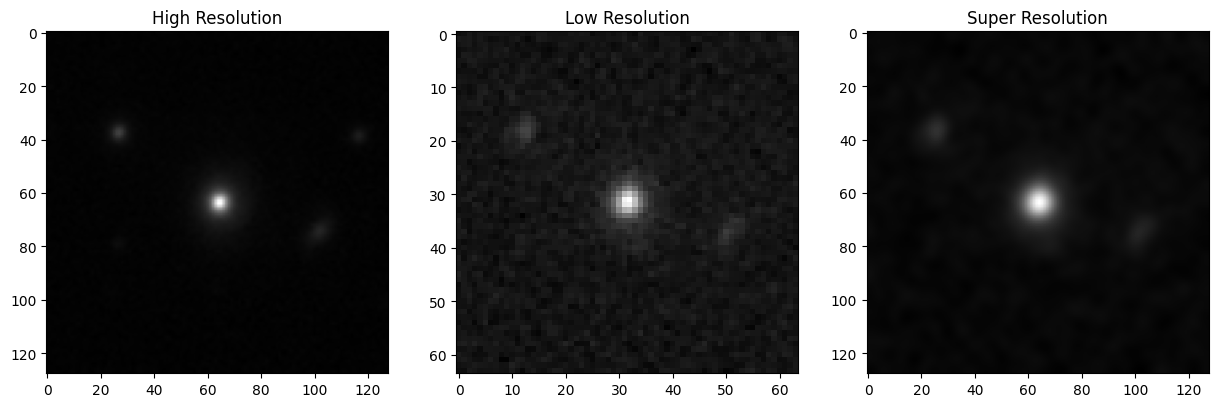

In [114]:
from skimage.metrics import peak_signal_noise_ratio
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import cv2


def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def psnr(y_true, y_pred):
    return peak_signal_noise_ratio(y_true, y_pred, data_range=y_pred.max() - y_pred.min())

def ssim_score(y_true, y_pred):
    return ssim(y_true, y_pred, data_range=y_pred.max() - y_pred.min())

#load the best model
model = WaveMixSR(
    depth = 4,
    mult = 1,
    ff_channel = 144,
    final_dim = 144,
    dropout = 0.2
).to(device)

model.load_state_dict(torch.load("best_model_WaveMixSR_V2.pth"))


#test the model
model.eval()
with torch.no_grad():
    high_res, low_res = test_dataset[0]
    high_res = high_res.unsqueeze(0).to(device)
    low_res = low_res.unsqueeze(0).to(device)

    output = model(low_res)

    high_res = high_res.cpu().numpy().squeeze(0)
    low_res = low_res.cpu().numpy().squeeze(0)
    output = output.cpu().numpy().squeeze(0)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    #changing dim
    high_res = np.transpose(high_res, (1, 2, 0))
    low_res = np.transpose(low_res, (1, 2, 0))
    output = np.transpose(output, (1, 2, 0))
    #unstack
    high_res = high_res[:,:,0]
    low_res = low_res[:,:,0]
    #avarage
    output = np.mean(output, axis=2)
    output = cv2.GaussianBlur(output, (11, 11), 0)

    

    ax[0].imshow(high_res , cmap="gray")
    ax[0].set_title("High Resolution" )
    ax[1].imshow(low_res , cmap="gray")
    ax[1].set_title("Low Resolution")
    ax[2].imshow(output , cmap="gray")
    ax[2].set_title("Super Resolution" )
    plt.show()





In [138]:
#average score for test set
import tqdm
scores = {"psnr": [], "mse": [], "ssim": []}
model = WaveMixSR(
    depth = 4,
    mult = 1,
    ff_channel = 144,
    final_dim = 144,
    dropout = 0.2
).to(device)

model.load_state_dict(torch.load("best_model_WaveMixSR.pth"))



model.eval()
for i in tqdm.tqdm(range(len(test_dataset))):
    with torch.no_grad():
        high_res, low_res = test_dataset[i]
        high_res = high_res.unsqueeze(0).to(device)
        low_res = low_res.unsqueeze(0).to(device)

        output = model(low_res)

        high_res = high_res.cpu().numpy().squeeze(0)
        low_res = low_res.cpu().numpy().squeeze(0)
        output = output.cpu().numpy().squeeze(0)

        #output = np.transpose(output, (1, 2, 0))

        #output = np.mean(output, axis=2)
        #output = cv2.GaussianBlur(output, (9, 9), 0)
        output = output[0]
        high_res = high_res[0]

            
        scores["psnr"].append(psnr(high_res, output))
        scores["mse"].append(mse(high_res, output))
        scores["ssim"].append(ssim_score(high_res, output))

print("Average PSNR: ", np.mean(scores["psnr"]))
print("Average MSE: ", np.mean(scores["mse"]))
print("Average SSIM: ", np.mean(scores["ssim"]))

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:00<00:00, 114.24it/s]

Average PSNR:  34.266821491320336
Average MSE:  0.00044689313
Average SSIM:  0.85012530061565


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of samples:  300
Sample 0:  torch.Size([3, 128, 128]) torch.Size([3, 64, 64])


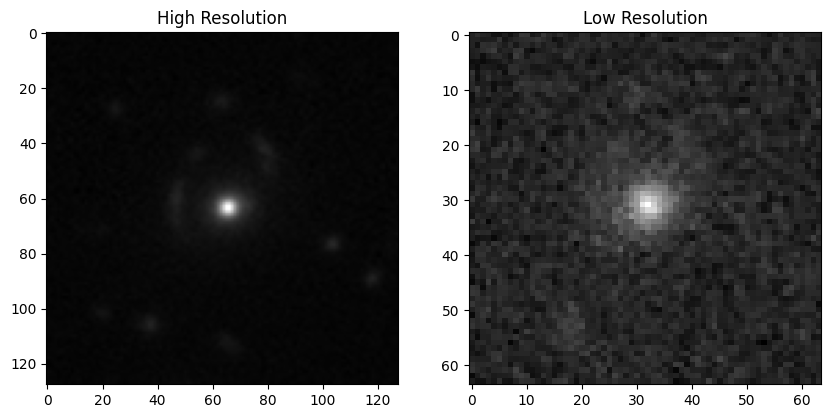

In [179]:
#Experimenting with data augmentation
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, high_res_folder, low_res_folder, highres_transform, lowres_transform, both_transforms=None):
        self.high_res_folder = high_res_folder
        self.low_res_folder = low_res_folder
        self.highres_transform = highres_transform
        self.lowres_transform = lowres_transform
        self.both_transforms = both_transforms

        #get the file names for both high and low res images
        self.file_names = [f.split(".")[0] for f in os.listdir(high_res_folder)]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        high_res_path = os.path.join(self.high_res_folder, f"HR_{self.file_names[idx].split('_')[-1]}.npy")
        low_res_path = os.path.join(self.low_res_folder, f"LR_{self.file_names[idx].split('_')[-1]}.npy")

        high_res_image = np.load(high_res_path)
        low_res_image = np.load(low_res_path)
        
        high_res_image = np.transpose(high_res_image, (1, 2, 0))
        low_res_image = np.transpose(low_res_image, (1, 2, 0))

        #grayscale to 3 channel
        high_res_image = np.stack((high_res_image,)*3, axis=-1)
        low_res_image = np.stack((low_res_image,)*3, axis=-1)

        #squeeze
        high_res_image = np.squeeze(high_res_image)
        low_res_image = np.squeeze(low_res_image)

        if self.highres_transform:
            high_res_image = self.highres_transform(high_res_image)

        if self.lowres_transform:
            low_res_image = self.lowres_transform(low_res_image)

        return high_res_image, low_res_image


#sizes
high_res_folder = "HR"
low_res_folder = "LR"

high_res_transform = transforms.Compose([
                                        transforms.ToTensor(),
])
                                        
low_res_transform = transforms.Compose([
                                        transforms.ToTensor(),

])

both_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
])

                                        

dataset = CustomDataset(high_res_folder, low_res_folder, high_res_transform, low_res_transform , both_transforms)
print("Number of samples: ", len(dataset))
print("Sample 0: ", dataset[0][0].shape, dataset[0][1].shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(dataset[0][0].permute(1, 2, 0) , cmap="gray")
ax[0].set_title("High Resolution")
ax[1].imshow(dataset[0][1].permute(1, 2, 0) , cmap="gray")
ax[1].set_title("Low Resolution")
plt.show()





In [180]:
#Training WaveMixSR
import torch
import torch.optim as optim
from alive_progress import alive_bar
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model
model = WaveMixSR(
    depth = 4,
    mult = 1,
    ff_channel = 144,
    final_dim = 144,
    dropout = 0.2
).to(device)

#loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

#dataloader
train_aize = int(0.8 * len(dataset))
test_size = len(dataset) - train_aize
train_dataset, test_dataset = random_split(dataset, [train_aize, test_size] )

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

#train
num_epochs = 200
train_losses = []
test_losses = []
best_loss = 1

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0
    model.train()
    with alive_bar(len(train_loader) , force_tty = True) as bar:
        for idx, (high_res, low_res) in enumerate(train_loader):
            high_res = high_res.to(device)
            low_res = low_res.to(device)
            optimizer.zero_grad()
            outputs = model(low_res)
            loss = criterion(outputs, high_res)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            #scheduler.step(loss)
            bar()
    
    model.eval()
    with torch.no_grad():
        for idx, (high_res, low_res) in enumerate(test_loader):
            high_res = high_res.to(device)
            low_res = low_res.to(device)

            outputs = model(low_res)
            loss = criterion(outputs, high_res)
            test_loss += loss.item()
    
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f}")

    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), "best_model_WaveMixSR_Augmentation.pth")
        print("Model saved")



|████████████████████████████████████████| 60/60 [100%] in 4.0s (14.95/s)       
Epoch 1/200, Train Loss: 0.58422257, Test Loss: 0.00719231
Model saved
|████████████████████████████████████████| 60/60 [100%] in 4.0s (15.01/s)       
Epoch 2/200, Train Loss: 0.01608829, Test Loss: 0.00619390
Model saved
|████████████████████████████████████████| 60/60 [100%] in 4.0s (14.94/s)       
Epoch 3/200, Train Loss: 0.01177842, Test Loss: 0.00604849
Model saved
|████████████████████████████████████████| 60/60 [100%] in 4.0s (14.94/s)       
Epoch 4/200, Train Loss: 0.00998784, Test Loss: 0.00607902
|████████████████████████████████████████| 60/60 [100%] in 4.0s (14.85/s)       
Epoch 5/200, Train Loss: 0.00901090, Test Loss: 0.00598219
Model saved
|████████████████████████████████████████| 60/60 [100%] in 4.0s (14.89/s)       
Epoch 6/200, Train Loss: 0.00847880, Test Loss: 0.00601227
|████████████████████████████████████████| 60/60 [100%] in 4.1s (14.65/s)       
Epoch 7/200, Train Loss: 0.0082

In [248]:
#average score for test set
import tqdm
scores = {"psnr": [], "mse": [], "ssim": []}
model = WaveMixSR(
    depth = 4,
    mult = 1,
    ff_channel = 144,
    final_dim = 144,
    dropout = 0.2
).to(device)

model.load_state_dict(torch.load("best_model_WaveMixSR_Augmentation.pth"))
dataset = CustomDataset(high_res_folder, low_res_folder, high_res_transform, low_res_transform )
train_aize = int(0.8 * len(dataset))
test_size = len(dataset) - train_aize
train_dataset, test_dataset = random_split(dataset, [train_aize, test_size] )



model.eval()
for i in tqdm.tqdm(range(len(test_dataset))):
    with torch.no_grad():
        high_res, low_res = test_dataset[i]
        high_res = high_res.unsqueeze(0).to(device)
        low_res = low_res.unsqueeze(0).to(device)

        output = model(low_res)

        high_res = high_res.cpu().numpy().squeeze(0)
        low_res = low_res.cpu().numpy().squeeze(0)
        output = output.cpu().numpy().squeeze(0)

        #output = np.transpose(output, (1, 2, 0))

        #output = np.mean(output, axis=2)
        #output = cv2.GaussianBlur(output, (9, 9), 0)
        output = output[0]
        high_res = high_res[0]

            
        scores["psnr"].append(psnr(high_res, output))
        scores["mse"].append(mse(high_res, output))
        scores["ssim"].append(ssim_score(high_res, output))

print("Average PSNR: ", np.mean(scores["psnr"]))
print("Average MSE: ", np.mean(scores["mse"]))
print("Average SSIM: ", np.mean(scores["ssim"]))

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:00<00:00, 146.04it/s]

Average PSNR:  33.197487564908954
Average MSE:  0.0007475245
Average SSIM:  0.8044471104120295
